In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge, Lasso, ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import joblib
from joblib import load
from sklearn.inspection import permutation_importance
archivo = "data-housing.xlsx" 
df = pd.read_excel(archivo)

df

,price,area,bedrooms,bathrooms,stories,guestroom,hotwaterheating,airconditioning,parking
0,13300000,7420,4,2,3,no,no,yes,2
1,12250000,8960,4,4,4,no,no,yes,3
2,12250000,9960,3,2,2,no,no,no,2
3,12215000,7500,4,2,2,no,no,yes,3
4,11410000,7420,4,1,2,yes,no,yes,2
...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,no,no,no,2
541,1767150,2400,3,1,1,no,no,no,0
542,1750000,3620,2,1,1,no,no,no,0
543,1750000,2910,3,1,1,no,no,no,0


In [2]:
def data_quality_analysis(df):
 
    result_df = pd.DataFrame(columns=['Columna', 'Tipo de dato', 'Valores únicos', 'Valores faltantes'])

    columns = df.columns
    data_types = df.dtypes.to_list()
    unique_values = [df[column].nunique() for column in columns]
    missing_values = [df[column].isnull().sum() for column in columns]

   
    result_df['Columna'] = columns
    result_df['Tipo de dato'] = data_types
    result_df['Valores únicos'] = unique_values
    result_df['Valores faltantes'] = missing_values

    return result_df

In [3]:
analysis_result = data_quality_analysis(df).set_index('Columna')
print(analysis_result.sort_values('Tipo de dato'))

                Tipo de dato  Valores únicos  Valores faltantes
Columna                                                        
price                  int64             219                  0
area                   int64             284                  0
bedrooms               int64               6                  0
bathrooms              int64               4                  0
stories                int64               4                  0
parking                int64               4                  0
guestroom             object               2                  0
hotwaterheating       object               2                  0
airconditioning       object               2                  0


In [4]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [5]:
def plot_boxplot_with_outliers(data, column_name, outlier_color='red', factor=1.5):
    # Calcular los estadísticos clave
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Calcular los límites para los valores atípicos
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR


    # Crear un gráfico de diagrama de caja (boxplot)
    plt.figure(figsize=(8,10))
    sns.boxplot(y=data[column_name], showfliers=False)
    # plt.title(f'Diagrama de Caja de {column_name}')
    plt.ylabel(column_name)
    plt.xlabel('Datos')

    # Resaltar los valores atípicos en un color diferente
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    plt.scatter(y=outliers[column_name], x=[0]*len(outliers), color=outlier_color, label='Outliers')

    # Anotar los valores de límites y cuartiles en el gráfico
    plt.text(0.35, Q1-0.55, f'Q1: {Q1:.2f}', fontsize=10)
    plt.text(0.35, Q3+0.3, f'Q3: {Q3:.2f}', fontsize=10)
    plt.text(0.205, lower_bound, f'Límite Inferior: {lower_bound:.2f}', fontsize=10)
    plt.text(0.205, upper_bound, f'Límite Superior: {upper_bound:.2f}', fontsize=10)

    plt.legend()
    plt.show()
    return outliers


Analizando outliers en: area


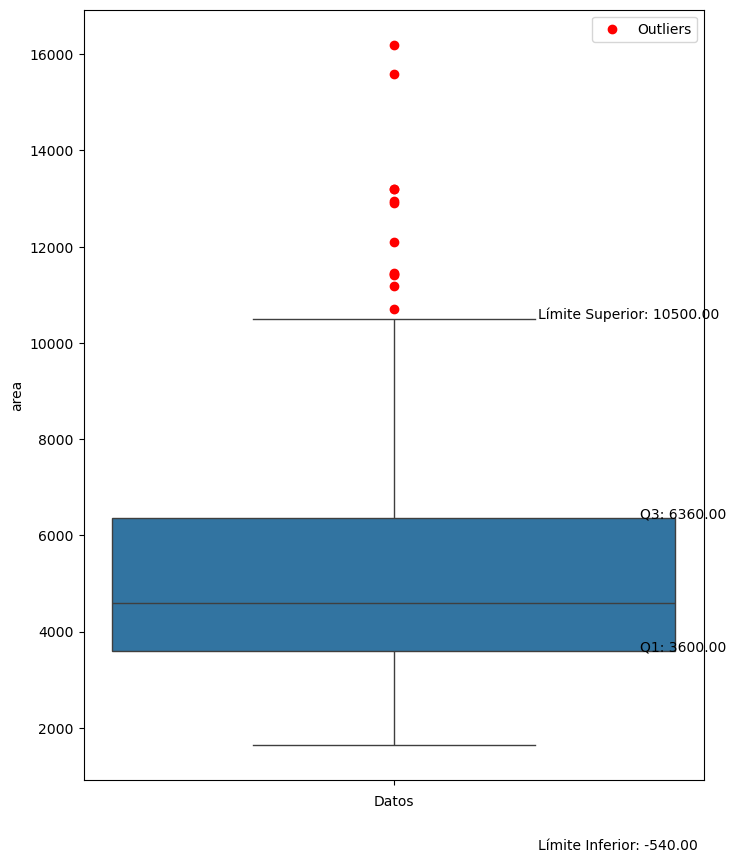

Número de outliers en area: 12

Analizando outliers en: price


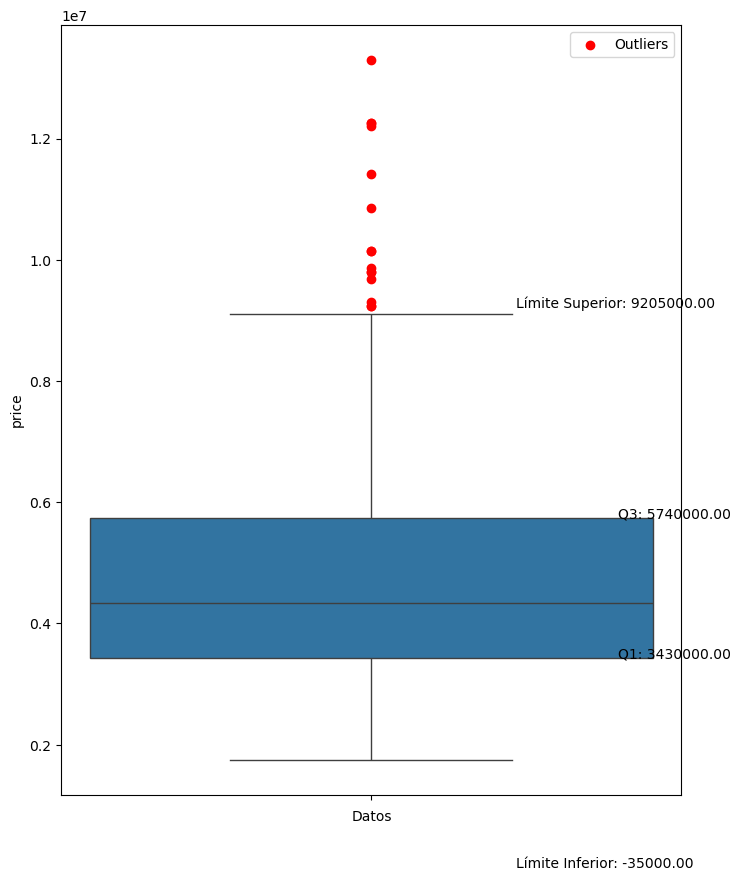

Número de outliers en price: 15


In [6]:
columns_to_analyze = ['area', 'price']
outliers_dict = {}  
for column in columns_to_analyze:
    print(f"\nAnalizando outliers en: {column}")
    outliers = plot_boxplot_with_outliers(df, column, outlier_color='red', factor=1.5)
    outliers_dict[column] = outliers
    print(f"Número de outliers en {column}: {len(outliers)}")

In [7]:
# Crear un diccionario para almacenar los encoders
label_encoders = {}

columns_to_encode = ['guestroom', 'hotwaterheating', 'airconditioning']

for col in columns_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Ajusta y transforma la columna
    label_encoders[col] = le

In [8]:
df

,price,area,bedrooms,bathrooms,stories,guestroom,hotwaterheating,airconditioning,parking
0,13300000,7420,4,2,3,0,0,1,2
1,12250000,8960,4,4,4,0,0,1,3
2,12250000,9960,3,2,2,0,0,0,2
3,12215000,7500,4,2,2,0,0,1,3
4,11410000,7420,4,1,2,1,0,1,2
...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,0,0,0,2
541,1767150,2400,3,1,1,0,0,0,0
542,1750000,3620,2,1,1,0,0,0,0
543,1750000,2910,3,1,1,0,0,0,0


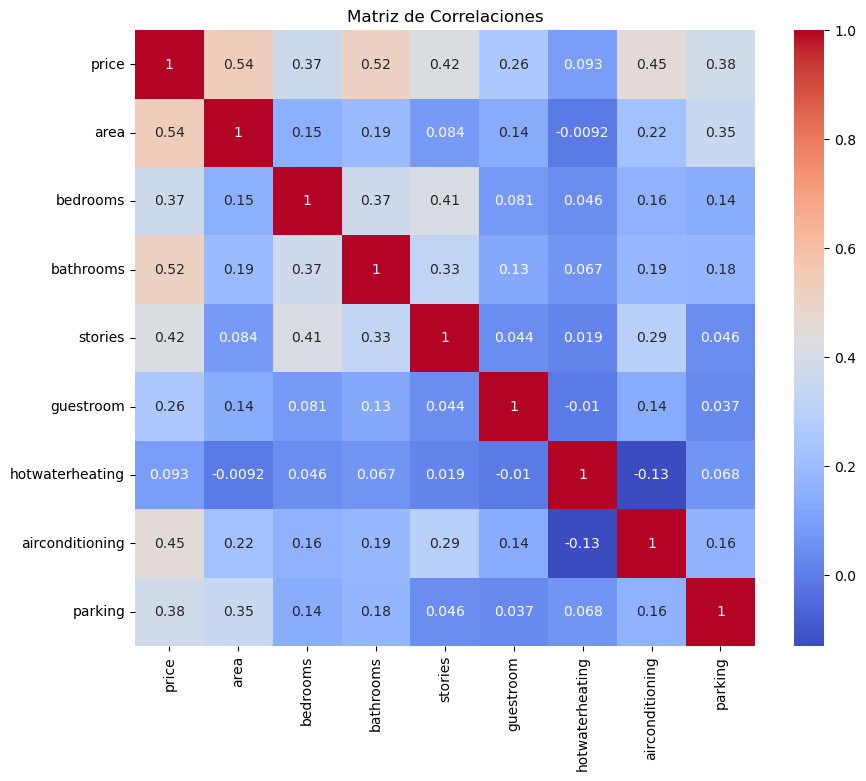

In [9]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlaciones')
plt.show()

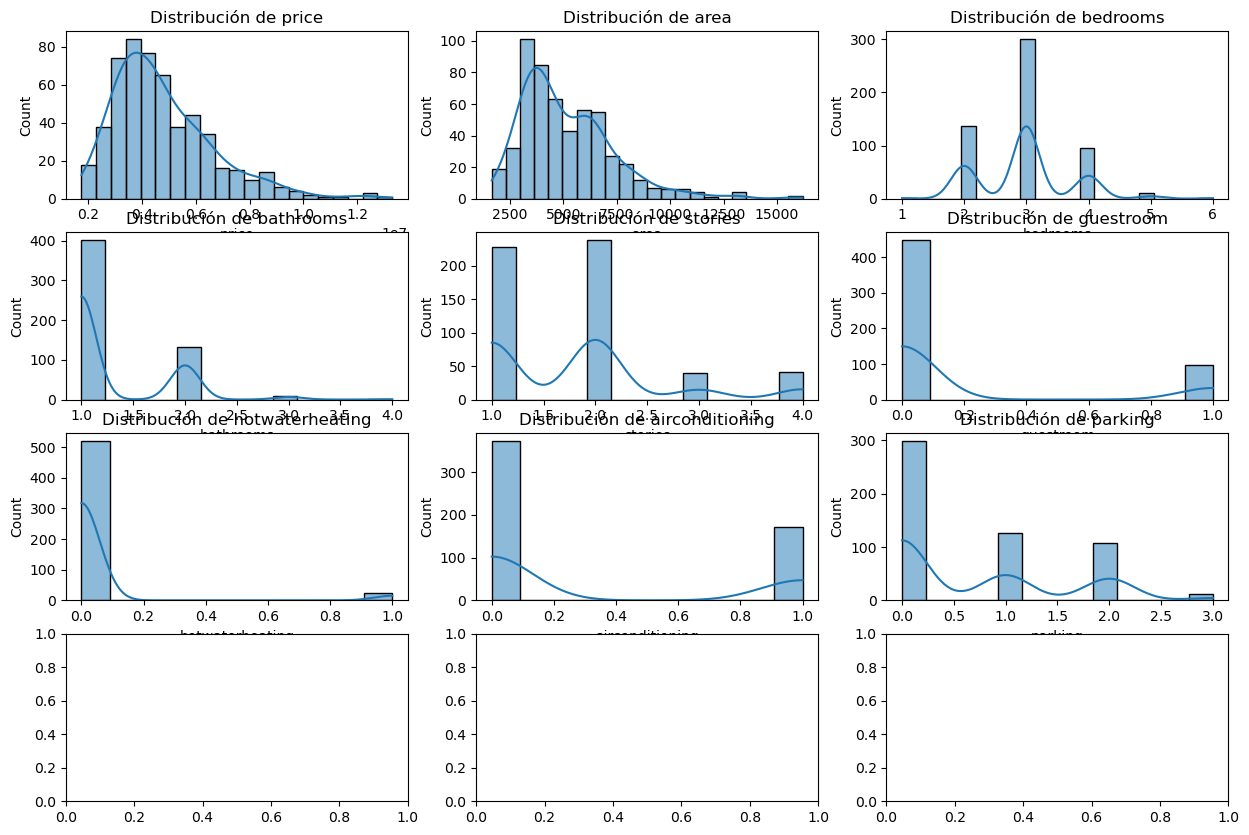

In [10]:
ncols = 3
n_rows = len(df.columns) // ncols + 1
fig, axes = plt.subplots(n_rows, ncols, figsize=(15, 10))
for i, col in enumerate(df.columns):
    ax = axes[i // ncols, i % ncols]
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    ax.set_title(f"Distribución de {col}")

In [11]:
from sklearn.feature_selection import f_regression
X = df.drop("price", axis=1)
y = df["price"]
f_values, p_values = f_regression(X, y)

anova = pd.DataFrame({
    "Variable": X.columns,
    "F-Value": f_values,
    "P-Value": p_values
}).sort_values(by="F-Value", ascending=False)

print("\n📈 ANOVA (Ranking de Variables):")
print(anova)


📈 ANOVA (Ranking de Variables):
          Variable     F-Value       P-Value
0             area  218.884081  7.388225e-42
2        bathrooms  198.654521  1.139322e-38
6  airconditioning  140.162721  6.310970e-29
3          stories  116.780402  8.668397e-25
7          parking   94.143328  1.238378e-20
1         bedrooms   84.251022  9.080302e-19
4        guestroom   37.928276  1.429114e-09
5  hotwaterheating    4.744870  2.981524e-02


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Normalización de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
models = {
    "LinearRegression": (LinearRegression(), {}),
    "Ridge": (Ridge(), {"alpha": [0.1, 1.0, 10.0]}),
    "Lasso": (Lasso(), {"alpha": [0.001, 0.01, 0.1, 1.0]}),
    "ElasticNet": (ElasticNet(), {"alpha": [0.01, 0.1, 1.0], "l1_ratio": [0.2, 0.5, 0.8]}),
    "Árbol de Decisión": (DecisionTreeRegressor(random_state=42), {"max_depth": [1,3, 5, 10, None], 
                                                                   "min_samples_split": [2, 5, 10,20]}),
    "RandomForest": (RandomForestRegressor(random_state=42), {"n_estimators": [100, 200,500], "max_depth": [None, 10, 20]})
}

In [15]:
results = []
# Iteramos sobre los modelos y sus hiperparámetros 
for name, (model, params) in models.items():
    print(f"🔍 Entrenando modelo: {name}")
    grid = GridSearchCV(model, params, cv=5, scoring="r2", n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    y_pred = grid.predict(X_test_scaled)
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "R2 Score": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred)
    })

🔍 Entrenando modelo: LinearRegression
🔍 Entrenando modelo: Ridge
🔍 Entrenando modelo: Lasso
🔍 Entrenando modelo: ElasticNet
🔍 Entrenando modelo: Árbol de Decisión
🔍 Entrenando modelo: RandomForest


C:\Users\gabby\AppData\Local\Temp\ipykernel_3592\4107127097.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
C:\Users\gabby\AppData\Local\Temp\ipykernel_3592\4107127097.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
C:\Users\gabby\AppData\Local\Temp\ipykernel_3592\4107127097.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
C:\Users\gabby\AppData\Local\Temp\ipykernel_3592\4107127097.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_t

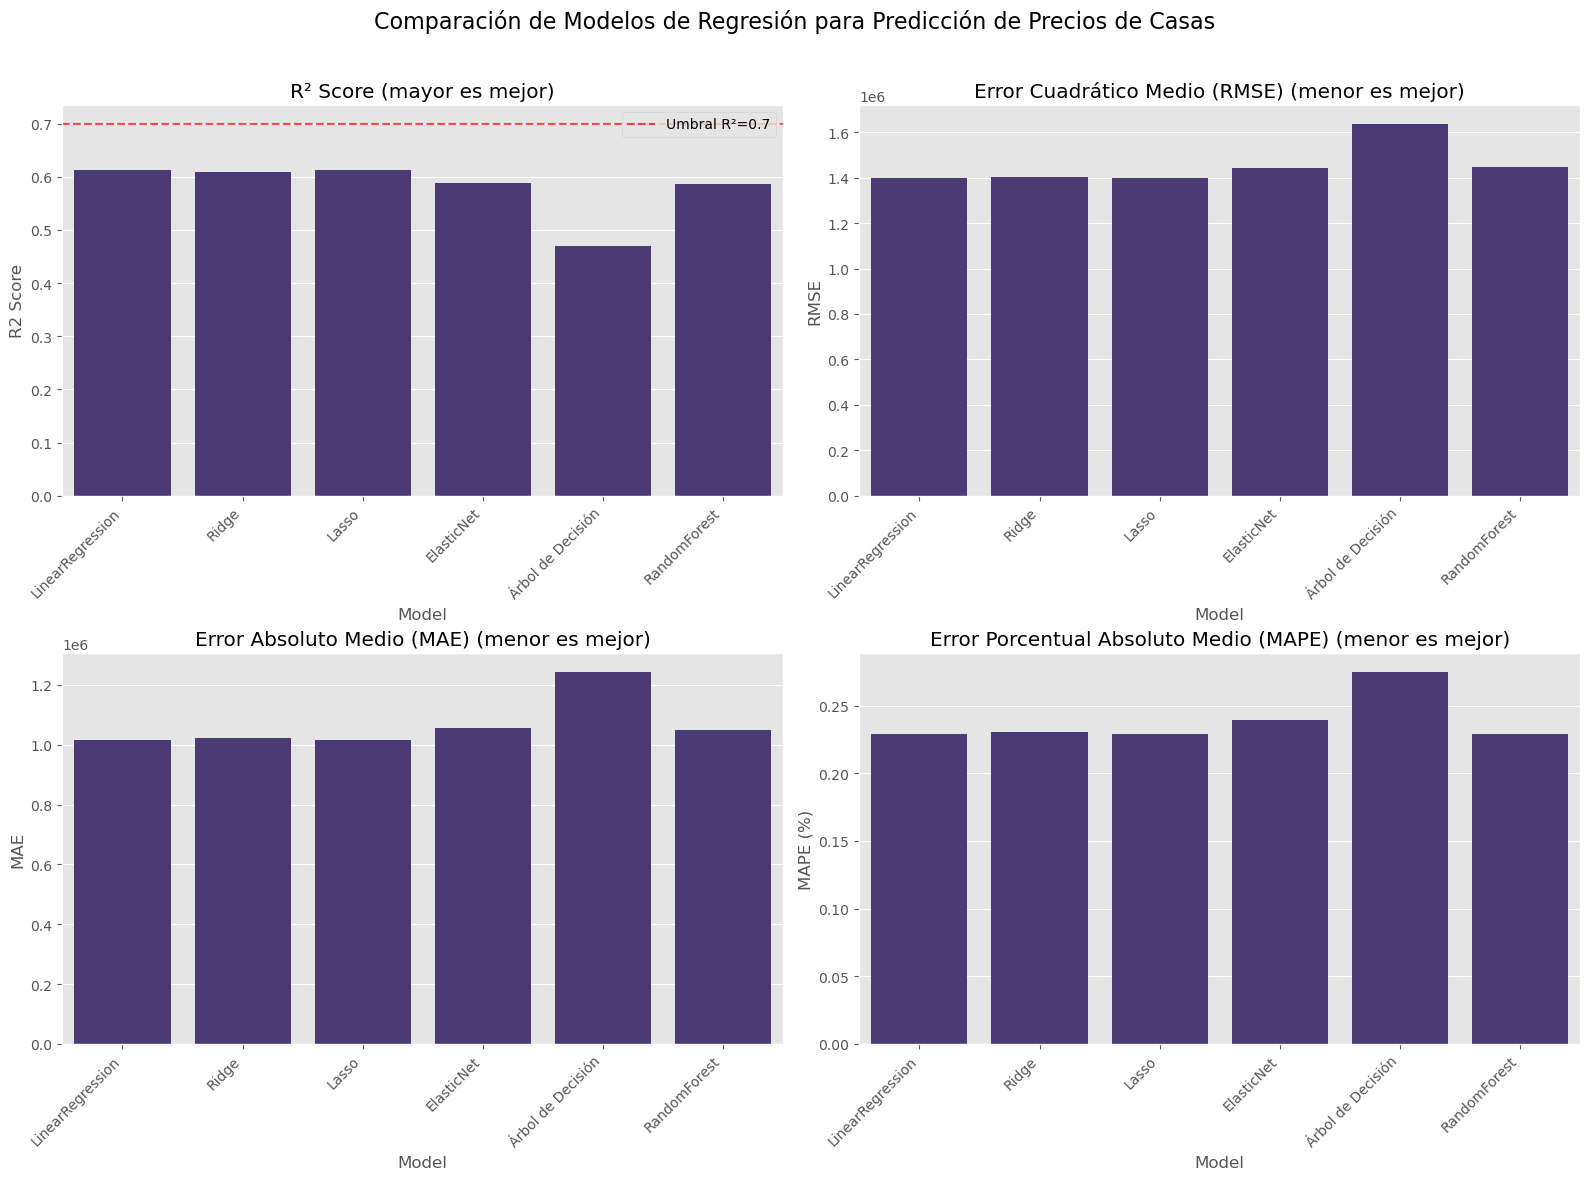


Tabla de Resultados (ordenada por R² Score):
            Model  R2 Score         RMSE          MAE   MAPE
 LinearRegression    0.6119 1400532.2837 1017374.1136 0.2292
            Lasso    0.6119 1400532.9393 1017374.8065 0.2292
            Ridge    0.6096 1404789.9657 1021388.3408 0.2303
       ElasticNet    0.5889 1441482.1275 1055062.5488 0.2391
     RandomForest    0.5855 1447435.7011 1047974.3105 0.2294
Árbol de Decisión    0.4689 1638379.4524 1243995.1661 0.2751

Mejor modelo: LinearRegression
Hiperparámetros óptimos: {}


In [16]:


# Convertir los resultados a un DataFrame para facilitar la visualización
results_df = pd.DataFrame(results)

# Configuración para visualizaciones más atractivas
plt.style.use('ggplot')
sns.set_palette("viridis")

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación de Modelos de Regresión para Predicción de Precios de Casas', fontsize=16)

# 1. Gráfico de R2 Score (superior izquierda)
sns.barplot(x='Model', y='R2 Score', data=results_df, ax=axes[0, 0])
axes[0, 0].set_title('R² Score (mayor es mejor)')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
axes[0, 0].axhline(y=0.7, color='r', linestyle='--', alpha=0.7, label='Umbral R²=0.7')
axes[0, 0].legend()

# 2. Gráfico de RMSE (superior derecha)
sns.barplot(x='Model', y='RMSE', data=results_df, ax=axes[0, 1])
axes[0, 1].set_title('Error Cuadrático Medio (RMSE) (menor es mejor)')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

# 3. Gráfico de MAE (inferior izquierda)
sns.barplot(x='Model', y='MAE', data=results_df, ax=axes[1, 0])
axes[1, 0].set_title('Error Absoluto Medio (MAE) (menor es mejor)')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

# 4. Gráfico de MAPE (inferior derecha)
sns.barplot(x='Model', y='MAPE', data=results_df, ax=axes[1, 1])
axes[1, 1].set_title('Error Porcentual Absoluto Medio (MAPE) (menor es mejor)')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].set_ylabel('MAPE (%)')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Mostrar también los resultados en una tabla ordenada por R2 Score descendente
print("\nTabla de Resultados (ordenada por R² Score):")
results_table = results_df.sort_values('R2 Score', ascending=False)[['Model', 'R2 Score', 'RMSE', 'MAE', 'MAPE']]
print(results_table.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Mostrar los mejores hiperparámetros del modelo con mejor rendimiento
best_model = results_df.loc[results_df['R2 Score'].idxmax()]['Model']
best_params = results_df.loc[results_df['R2 Score'].idxmax()]['Best Params']
print(f"\nMejor modelo: {best_model}")
print(f"Hiperparámetros óptimos: {best_params}")

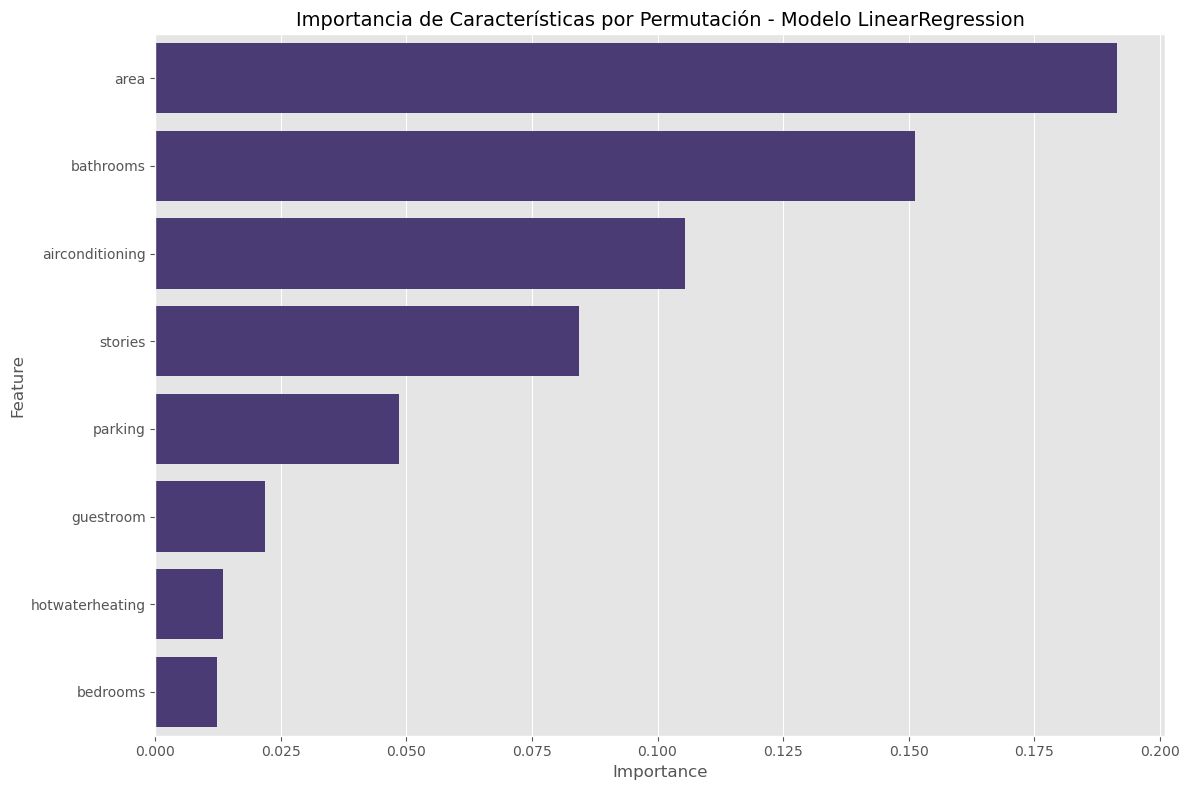

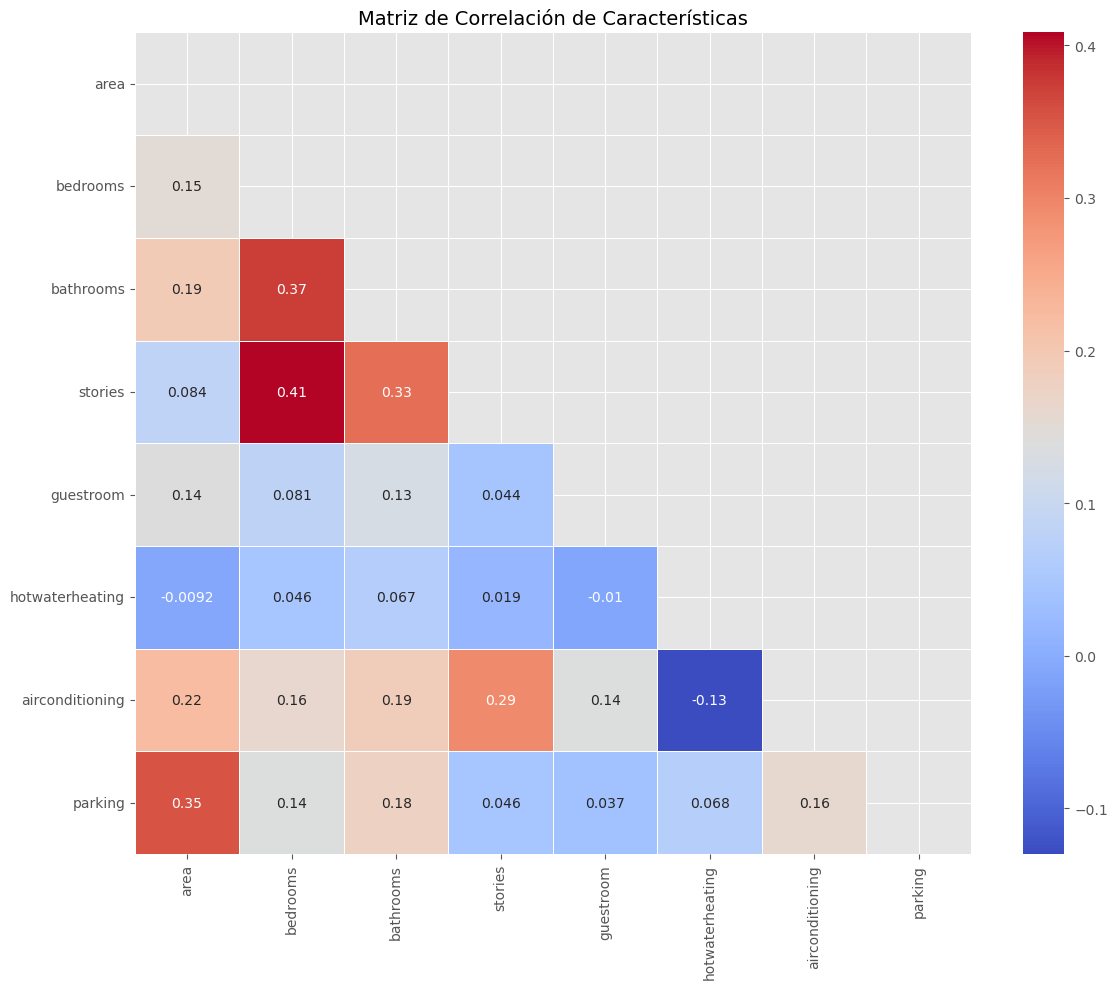


Detección de Multicolinealidad:
No se detectaron problemas graves de multicolinealidad.


In [17]:
# Identificar el mejor modelo
best_model_name = results_df.loc[results_df['R2 Score'].idxmax()]['Model']
best_model = None

# Obtener el mejor modelo (necesitamos reentrenarlo)
for name, (model, params) in models.items():
    if name == best_model_name:
        if params:  # Si tiene hiperparámetros para ajustar
            grid = GridSearchCV(model, params, cv=5, scoring="r2", n_jobs=-1)
            grid.fit(X_train_scaled, y_train)
            best_model = grid.best_estimator_
        else:  # Si no tiene hiperparámetros para ajustar
            model.fit(X_train_scaled, y_train)
            best_model = model
        break

# Análisis de características
feature_names = X.columns

# Método 1: Análisis de importancia de características para RandomForest o DecisionTree
if best_model_name in ["RandomForest", "Árbol de Decisión"]:
    feature_importances = best_model.feature_importances_
    
    # Crear DataFrame y ordenar por importancia
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)
    
    # Visualizar importancia de características
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Importancia de Características del Modelo {best_model_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Método 2: Permutation Importance (funciona con cualquier modelo)
result = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Crear DataFrame y ordenar por importancia
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

# Visualizar importancia de características por permutación
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df)
plt.title(f'Importancia de Características por Permutación - Modelo {best_model_name}', fontsize=14)
plt.tight_layout()
plt.show()

# Análisis adicional: Matriz de correlación de características
plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)
plt.title('Matriz de Correlación de Características', fontsize=14)
plt.tight_layout()
plt.show()

# Detectar posibles problemas de multicolinealidad
print("\nDetección de Multicolinealidad:")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:  # Umbral de correlación alta
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

if high_corr_pairs:
    print("Se detectaron correlaciones altas entre características:")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"- {feat1} y {feat2}: {corr:.4f}")
    print("\nRecomendación: Considerar eliminar una de cada par de características altamente correlacionadas.")
else:
    print("No se detectaron problemas graves de multicolinealidad.")

Entrenando modelos avanzados...

Resultados del Gradient Boosting:
Model: GradientBoosting
Best Params: {'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.05}
R2 Score: 0.6219276907027584
MAE: 1025197.8790466285
RMSE: 1382386.7206922786
MAPE: 0.2270089016695638

Resultados del modelo de Stacking:
Model: Stacking
Best Params: N/A
R2 Score: 0.6395571213922909
MAE: 987193.1725291039
RMSE: 1349771.7769025916
MAPE: 0.22111866682248205


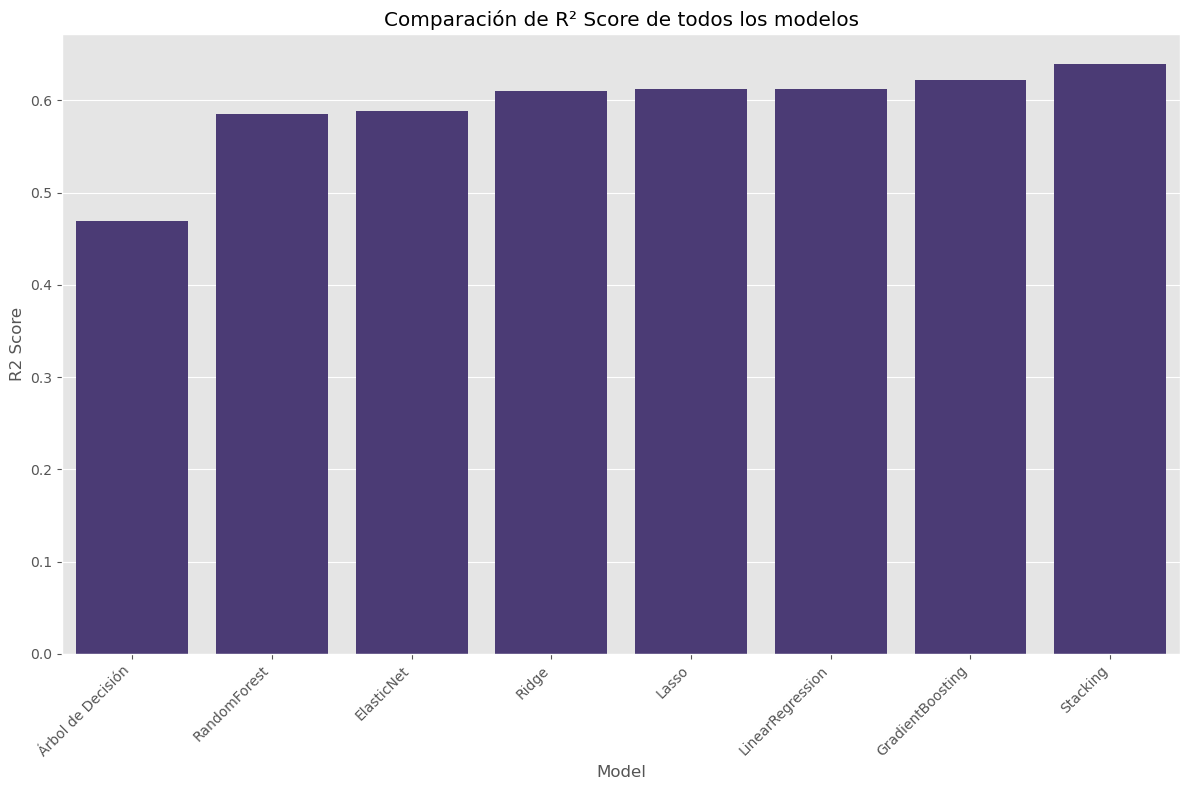

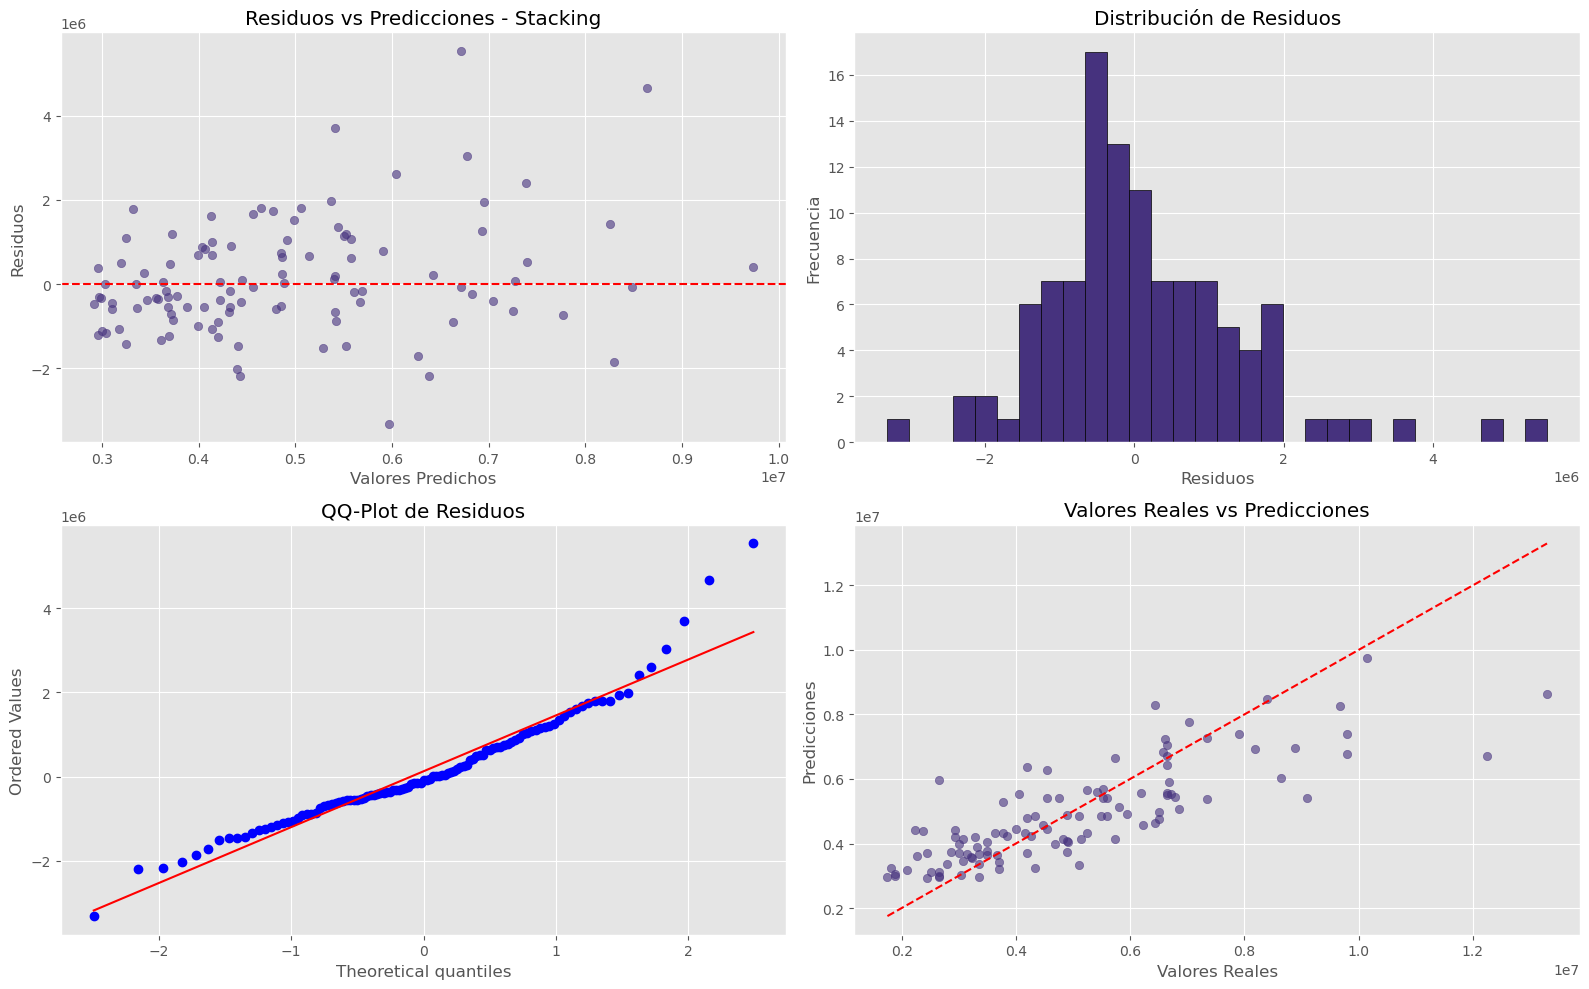


Precio estimado para la casa de ejemplo: $6,420,970.03


In [18]:
print("Entrenando modelos avanzados...")

# Gradient Boosting con búsqueda aleatoria de hiperparámetros (más eficiente que Grid Search)
gb_params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

gb_model = GradientBoostingRegressor(random_state=42)
gb_random_search = RandomizedSearchCV(gb_model, param_distributions=gb_params, 
                                     n_iter=20, cv=5, scoring='r2', random_state=42, n_jobs=-1)
gb_random_search.fit(X_train_scaled, y_train)

# Evaluación del modelo de Gradient Boosting
y_pred_gb = gb_random_search.predict(X_test_scaled)
gb_results = {
    "Model": "GradientBoosting",
    "Best Params": gb_random_search.best_params_,
    "R2 Score": r2_score(y_test, y_pred_gb),
    "MAE": mean_absolute_error(y_test, y_pred_gb),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_gb)),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_gb)
}

print("\nResultados del Gradient Boosting:")
for key, value in gb_results.items():
    print(f"{key}: {value}")

# 2. Modelo de Stacking (combina varios modelos)
# Obtenemos los mejores modelos individuales
best_rf = None
best_ridge = None
best_lasso = None

for name, (model, params) in models.items():
    if name == "RandomForest":
        grid = GridSearchCV(model, params, cv=5, scoring="r2", n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_rf = grid.best_estimator_
    elif name == "Ridge":
        grid = GridSearchCV(model, params, cv=5, scoring="r2", n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_ridge = grid.best_estimator_
    elif name == "Lasso":
        grid = GridSearchCV(model, params, cv=5, scoring="r2", n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_lasso = grid.best_estimator_

# Crear modelo de stacking con los mejores modelos individuales
estimators = [
    ('rf', best_rf),
    ('ridge', best_ridge),
    ('lasso', best_lasso),
    ('gb', gb_random_search.best_estimator_)
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(),
        passthrough=False,
    n_jobs=-1
)

stacking_model.fit(X_train_scaled, y_train)
y_pred_stack = stacking_model.predict(X_test_scaled)

stack_results = {
    "Model": "Stacking",
    "Best Params": "N/A",
    "R2 Score": r2_score(y_test, y_pred_stack),
    "MAE": mean_absolute_error(y_test, y_pred_stack),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_stack)),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_stack)
}

print("\nResultados del modelo de Stacking:")
for key, value in stack_results.items():
    print(f"{key}: {value}")

# Actualizar nuestro DataFrame de resultados con los nuevos modelos
new_results = results.copy()
new_results.append(gb_results)
new_results.append(stack_results)
new_results_df = pd.DataFrame(new_results)

# Visualizar todos los resultados
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='R2 Score', data=new_results_df.sort_values('R2 Score'))
plt.title('Comparación de R² Score de todos los modelos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Análisis de residuos del mejor modelo
best_idx = new_results_df['R2 Score'].idxmax()
best_model_name = new_results_df.loc[best_idx, 'Model']

# Determinar las predicciones del mejor modelo
if best_model_name == "GradientBoosting":
    best_predictions = y_pred_gb
elif best_model_name == "Stacking":
    best_predictions = y_pred_stack
else:
    # Para los modelos originales, necesitamos reentrenar
    for name, (model, params) in models.items():
        if name == best_model_name:
            grid = GridSearchCV(model, params, cv=5, scoring="r2", n_jobs=-1)
            grid.fit(X_train_scaled, y_train)
            best_predictions = grid.predict(X_test_scaled)
            break

# Análisis de residuos
residuals = y_test - best_predictions

plt.figure(figsize=(16, 10))

# Gráfico de residuos vs predicciones
plt.subplot(2, 2, 1)
plt.scatter(best_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Residuos vs Predicciones - {best_model_name}')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')

# Histograma de residuos
plt.subplot(2, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribución de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')

# QQ-plot para verificar normalidad de residuos
plt.subplot(2, 2, 3)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ-Plot de Residuos')

# Predicciones vs valores reales
plt.subplot(2, 2, 4)
plt.scatter(y_test, best_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Valores Reales vs Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

plt.tight_layout()
plt.show()

# 4. Preparar una función para predicciones en nuevos datos
def predict_house_price(area, bedrooms, bathrooms, stories, guestroom='no',
                        hotwaterheating='no', airconditioning='no', parking=0):
    """
    Predice el precio de una casa según sus características.

    Parámetros:
    - area: superficie en pies cuadrados
    - bedrooms: número de dormitorios
    - bathrooms: número de baños
    - stories: número de pisos
    - guestroom: 'yes' o 'no'
    - hotwaterheating: 'yes' o 'no'
    - airconditioning: 'yes' o 'no'
    - parking: número de estacionamientos

    Retorna:
    - Precio estimado de la casa
    """
    # Crear un DataFrame con los datos de entrada (MOVER ESTA LÍNEA AQUÍ)
    input_data = pd.DataFrame({
        'area': [area],
        'bedrooms': [bedrooms],
        'bathrooms': [bathrooms],
        'stories': [stories],
        'guestroom': [guestroom],
        'hotwaterheating': [hotwaterheating],
        'airconditioning': [airconditioning],
        'parking': [parking]
    })

    # Aplicar la misma transformación que a los datos de entrenamiento
    for col in ['guestroom', 'hotwaterheating', 'airconditioning']:
        if col in input_data.columns and col in label_encoders: # Asegurarse de usar label_encoders global
            if input_data[col][0] not in label_encoders[col].classes_:
                input_data[col] = [label_encoders[col].classes_[0]]

            # Codificar la columna con el LabelEncoder
            input_data[col] = label_encoders[col].transform(input_data[col])
        elif col in input_data.columns:
            print(f"Advertencia: No se encontró LabelEncoder para la columna '{col}'")

    # Escalar los datos (asegurándote de usar el mismo escalador que usaste en el entrenamiento)
    input_data_scaled = scaler.transform(input_data)

    # Realizar la predicción con el mejor modelo
    # (Asumiendo que 'best_model' está definido globalmente o se pasa a la función)
    if best_model_name == "GradientBoosting":
        prediction = gb_random_search.predict(input_data_scaled)[0]
    elif best_model_name == "Stacking":
        prediction = stacking_model.predict(input_data_scaled)[0]
    else:
        # Para los modelos originales
        for name, (model, params) in models.items():
            if name == best_model_name:
                grid = GridSearchCV(model, params, cv=5, scoring="r2", n_jobs=-1)
                grid.fit(X_train_scaled, y_train)
                prediction = grid.predict(input_data_scaled)[0]
                break

    return prediction

# Ejemplo de uso de la función
ejemplo_casa = {
    'area': 2500,
    'bedrooms': 3,
    'bathrooms': 2,
    'stories': 2,
    'guestroom': 'yes',
    'hotwaterheating': 'yes',
    'airconditioning': 'yes',
    'parking': 2
}

precio_estimado = predict_house_price(**ejemplo_casa)
print(f"\nPrecio estimado para la casa de ejemplo: ${precio_estimado:,.2f}")

In [19]:
import pickle

with open('best_model.pkl', 'wb') as archivo:
    pickle.dump(best_model, archivo)


In [20]:
with open('scaler.pkl', 'wb') as archivo:
    pickle.dump(scaler, archivo)

In [21]:
with open('label_encoders.pkl', 'wb') as archivo:
    pickle.dump(label_encoders, archivo)

In [22]:
train_cols = X_train.columns.tolist()
with open('train_columns.pkl', 'wb') as archivo:
    pickle.dump(train_cols, archivo)